In [1]:

import ccxt
from datetime import datetime as dt,timedelta
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt
import warnings
import plotly.graph_objects as go

warnings.filterwarnings('ignore')

# from pandas.tseries.offsets import BDay

# !pip install -U vectorbt
ex = ccxt.ftx({'enableRateLimit':True})


In [2]:
# Get Data 

def get_data(symbols:str  , **kwarg ):

    data= pd.DataFrame(ex.fetch_ohlcv(symbols,**kwarg ),columns=['date','open','high','low','close','volume'])
#         data.drop(columns='volume',inplace=True)
    data['date']=data['date'].apply(ex.iso8601)
    data['date']=pd.to_datetime(data['date'])
#   df['date']=df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
#   df['date']=pd.to_datetime(df['date'])
    data.set_index('date',inplace=True)

    return data

def cal_consecutive(df:pd.DataFrame):

    df['win']= np.sign(df) # assign sign on log
    blocks = df['win'].ne(df['win'].shift()).cumsum() 
    df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
    return df['consecutive_WL'] 




# to do update ,save
# vectorbt data class 


In [3]:
def scale_data(symbol,**kwarg):
    df  =get_data(symbol,**kwargs)

    df['scale_close'] = (df['close'] - df['close'].min()) / (df['close'].max() -df['close'].min())
    return df


In [4]:
df1 = get_data('ZIL-PERP',**{'timeframe':'4h'})
df1['ret'] = np.log(df1['close']/df1['close'].shift(1))
df1['consec_wl'] = cal_consecutive(df1['ret'])
df1['mae'] =(df1['low'] - df1['close'].shift(1) ) /df1['close'].shift(1)  
df1['mfe'] =(df1['high'] - df1['close'].shift(1) ) /df1['close'].shift(1)  
df1['pnl'] = (df1['close'] -df1['close'].shift(1) ) / df1['close'].shift(1) 

df1['volatile'] = df1['mfe'] +abs(df1['mae']) *  (np.where(df1['mfe'] >= abs(df1['mae']) ,1,-1)) # real volatility 
df1.dropna(inplace=True)
df1[['pnl','mae','mfe','volatile']].describe()

,pnl,mae,mfe,volatile
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.001062,-0.018257,0.018676,0.007950
std,0.026742,0.019860,0.022798,0.039155
min,-0.138043,-0.312468,-0.000363,-0.288701
25%,-0.011794,-0.024109,0.006572,-0.015163
50%,0.001110,-0.013023,0.013369,-0.000223
75%,0.013644,-0.006306,0.024498,0.030327
max,0.362494,0.000000,0.396852,0.403209


In [5]:
df1['vwap'] = df1.ta.vwap(period=3)
df1[['close','vwap']]#.plot()


,close,vwap
date,,
2021-07-24 16:00:00+00:00,0.06469,0.065190
2021-07-24 20:00:00+00:00,0.06456,0.064832
2021-07-25 00:00:00+00:00,0.06300,0.063373
2021-07-25 04:00:00+00:00,0.06698,0.065025
2021-07-25 08:00:00+00:00,0.06761,0.066085
...,...,...
2022-03-30 20:00:00+00:00,0.17995,0.152523
2022-03-31 00:00:00+00:00,0.19632,0.196290
2022-03-31 04:00:00+00:00,0.19392,0.197108


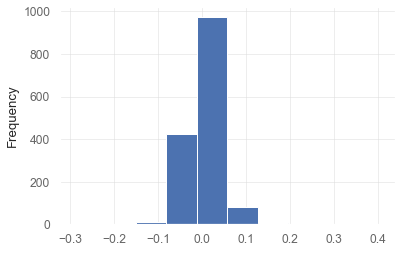

In [6]:
df1['volatile'].plot.hist()


1500

In [7]:
max_ret = df1.groupby('consec_wl').max()['ret']
min_ret= df1.groupby('consec_wl').min()['ret']
avg_ret = df1.groupby('consec_wl').mean()['ret']
count_ret  = df1.groupby('consec_wl').count()['ret']

In [12]:
wl_data =pd.concat([max_ret,min_ret,avg_ret,count_ret],axis=1)
wl_data.columns = ['max_ret','min_ret','avg_ret','count_ret']
wl_data['pct_count_ret'] = wl_data['count_ret'] / len(df1) *100
wl_data

,max_ret,min_ret,avg_ret,count_ret,pct_count_ret
consec_wl,,,,,
-12.0,-0.011312,-0.011312,-0.011312,1,0.066667
-11.0,-0.001713,-0.001713,-0.001713,1,0.066667
-10.0,-0.004588,-0.004588,-0.004588,1,0.066667
-9.0,-0.005520,-0.005520,-0.005520,1,0.066667
-8.0,-0.007068,-0.007068,-0.007068,1,0.066667
-7.0,-0.015852,-0.015852,-0.015852,1,0.066667
-6.0,-0.004439,-0.036058,-0.014640,7,0.466667
-5.0,-0.004056,-0.148550,-0.041333,15,1.000000
-4.0,-0.000198,-0.092050,-0.022495,34,2.266667


# Sort Values Wins Days

In [13]:
df1.sort_values('ret',ascending=False).head(10)


,open,high,low,close,volume,ret,consec_wl,mae,mfe,pnl,volatile,vwap
date,,,,,,,,,,,,
2022-03-26 20:00:00+00:00,0.06607,0.09229,0.06565,0.09002,7.828651e+07,0.309317,6.0,-0.006357,0.396852,0.362494,0.403209,0.073078
2022-03-30 04:00:00+00:00,0.11679,0.15144,0.11449,0.14214,1.255433e+08,0.196435,4.0,-0.019693,0.296686,0.217056,0.316380,0.129920
2022-03-27 12:00:00+00:00,0.09604,0.11841,0.09542,0.11139,1.290067e+08,0.148273,2.0,-0.006456,0.232924,0.159829,0.239379,0.097523
2022-03-30 00:00:00+00:00,0.10283,0.11798,0.09829,0.11679,4.054312e+07,0.127300,3.0,-0.044151,0.147331,0.135758,0.191481,0.111020
2022-03-26 16:00:00+00:00,0.05834,0.06743,0.05748,0.06607,2.945341e+07,0.124427,5.0,-0.014741,0.155811,0.132499,0.170552,0.059549
2022-03-30 16:00:00+00:00,0.15314,0.17774,0.15000,0.17310,1.134386e+08,0.122517,1.0,-0.020504,0.160637,0.130338,0.181141,0.149093
2022-03-30 08:00:00+00:00,0.14213,0.16362,0.13995,0.15921,1.351212e+08,0.113412,5.0,-0.015407,0.151119,0.120093,0.166526,0.140839
2021-09-10 00:00:00+00:00,0.10836,0.12113,0.10824,0.11897,2.814825e+06,0.093412,2.0,-0.001107,0.117848,0.097914,0.118955,0.116113
2021-11-29 04:00:00+00:00,0.08534,0.09344,0.08517,0.09343,3.453679e+06,0.090569,3.0,-0.001992,0.094914,0.094797,0.096906,0.089884


# Sort Values Loss Days

In [14]:
df1.sort_values('ret',ascending=True).head(10)


,open,high,low,close,volume,ret,consec_wl,mae,mfe,pnl,volatile,vwap
date,,,,,,,,,,,,
2021-09-07 12:00:00+00:00,0.11996,0.12104,0.08653,0.10334,7.958891e+06,-0.148550,-5.0,-0.278255,0.009592,-0.138043,-0.268663,0.112330
2021-12-04 04:00:00+00:00,0.07700,0.07883,0.05294,0.06687,8.026875e+06,-0.141055,-5.0,-0.312468,0.023766,-0.131558,-0.288701,0.067433
2022-01-22 04:00:00+00:00,0.04863,0.04887,0.04337,0.04358,1.060819e+06,-0.109642,-1.0,-0.108164,0.004935,-0.103845,-0.103228,0.046766
2021-09-24 08:00:00+00:00,0.09116,0.09185,0.07924,0.08244,2.833484e+06,-0.101203,-1.0,-0.131331,0.006906,-0.096251,-0.124424,0.086280
2022-02-24 00:00:00+00:00,0.03889,0.03919,0.03500,0.03547,1.077721e+06,-0.092050,-4.0,-0.100026,0.007714,-0.087940,-0.092312,0.036553
2021-11-26 08:00:00+00:00,0.08745,0.08751,0.07905,0.08033,2.491506e+06,-0.085038,-4.0,-0.096158,0.000572,-0.081523,-0.095587,0.085083
2021-12-31 16:00:00+00:00,0.07964,0.07975,0.07328,0.07361,2.198626e+06,-0.078610,-1.0,-0.079744,0.001507,-0.075600,-0.078237,0.077472
2021-08-24 12:00:00+00:00,0.11956,0.11959,0.11008,0.11053,3.645492e+06,-0.078531,-2.0,-0.079291,0.000251,-0.075527,-0.079040,0.116555
2022-01-05 16:00:00+00:00,0.07257,0.07276,0.06677,0.06731,1.133054e+06,-0.075243,-1.0,-0.079923,0.002618,-0.072482,-0.077305,0.070727


In [10]:
def ohlc_chart(df,rec):
        '''
        df = ohlc pd.DataFrame
        rec = record from vbt  pd.DataFrame 
        '''
        mark_up =0.99
        mark_down = 1.01
        fig = go.Figure(data=[go.Ohlc(x=df.index,open=df.open, high=df.high,low=df.low, close=df.close,increasing_line_color= '#8080FF', decreasing_line_color= '#8080FF',name='ohlc')])
        fig.add_trace(go.Scatter(x=rec.ent_date,y=rec.ent_mark *mark_up,name='buy',mode="markers",marker=dict(symbol='triangle-up', size = 15,color='green'),))
        fig.add_trace(go.Scatter(x=rec.exit_date,y=rec.exit_mark *mark_down,name='sell',mode="markers",marker=dict(symbol='triangle-down', size = 15,color='red'),))
        fig.update(layout_xaxis_rangeslider_visible=False)
        fig.update_layout(title_text='Close Price',width=1000,height=500,)

        return fig


def plot_indi(df,rec,indi:str , mark_up =0.8 ,mark_down =1.2,show_arrow=True):
    '''
    df = ohlc 
    rec = record DataFrame
    indi = indicator name [str ] 
    markup ,markdown = float 
    '''
    
    fig = df[indi].vbt.plot(hovermode='x unified') # Show Values on mark
    if show_arrow:
        ent_df = df.loc[rec.ent_date]
        end_df = df.loc[rec.exit_date]
        fig.add_trace(go.Scatter(x=rec.ent_date,y=ent_df[indi] *mark_up,name='buy',mode="markers",marker=dict(symbol='triangle-up', size = 15,color='green'),))
        fig.add_trace(go.Scatter(x=rec.exit_date,y=end_df[indi] *mark_down,name='sell',mode="markers",marker=dict(symbol='triangle-down', size = 15,color='red'),))
    return fig


def plot_dist(series_name ,name_label= [''],title_text= 'Histrogram and Curve plot'):
        ''' series_name = pd.Series
        name_label = text on list List
        title_text = String '''
        x1 =series_name.dropna()
        group_labels = name_label
        colors = ['#8080FF']
        # Create distplot with curve_type set to 'normal'  # override default 'kde'
        fig = ff.create_distplot([x1], group_labels, bin_size=0.8,curve_type='normal',colors=colors,show_curve=True,show_rug=False)
        fig.update_layout(title_text=title_text,width=800,height=400)
        return fig

def plot_hist(series_name,title_text='Histrogram'):
        ''' series_name = pd.Series
        title_text = String
        '''
        series_name = series_name.dropna()
        hist_fig = go.Figure(data=[go.Histogram(x=series_name, histnorm='probability')])
        hist_fig.update_layout(title_text=title_text,width=800,height=400)
        hist_fig.update_traces(opacity=0.5)
        return hist_fig


# Visualize

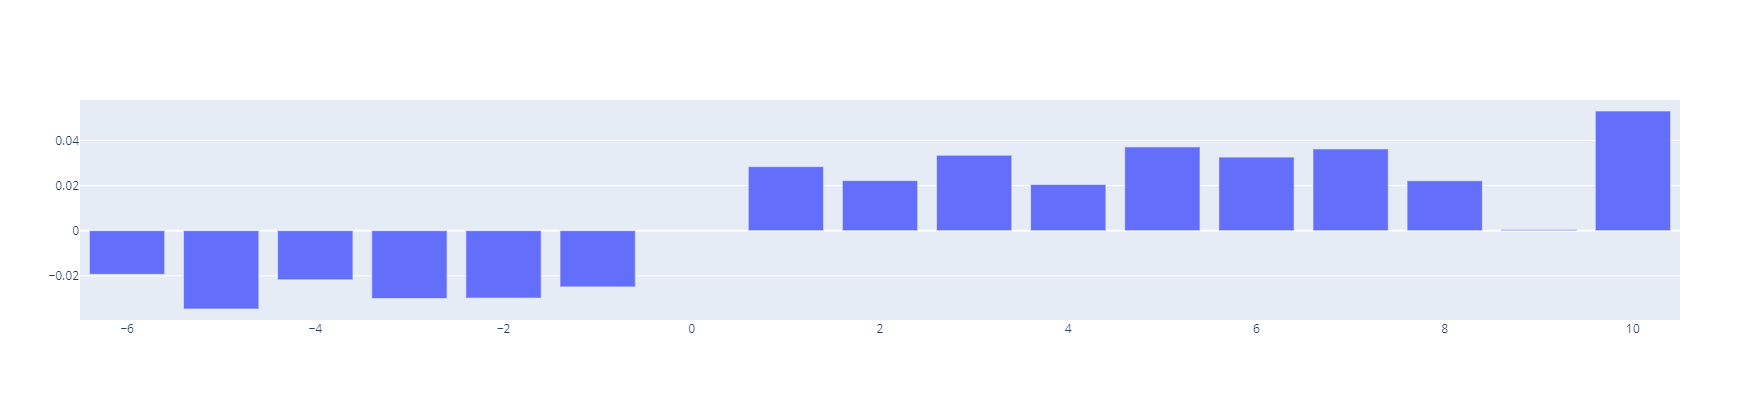

In [21]:
# sns.barplot(data=wl_data,x=wl_data.index,y='count_ret')
import plotly.graph_objects as go
import plotly.figure_factory as ff

fig = go.Figure(data=[
    go.Bar(name='Avg Return by W/L Sign ', x=wl_data.index, y=wl_data.avg_ret),])
# Change the bar mode
fig.update_layout(barmode='group',width=800,height=400)
fig.show()

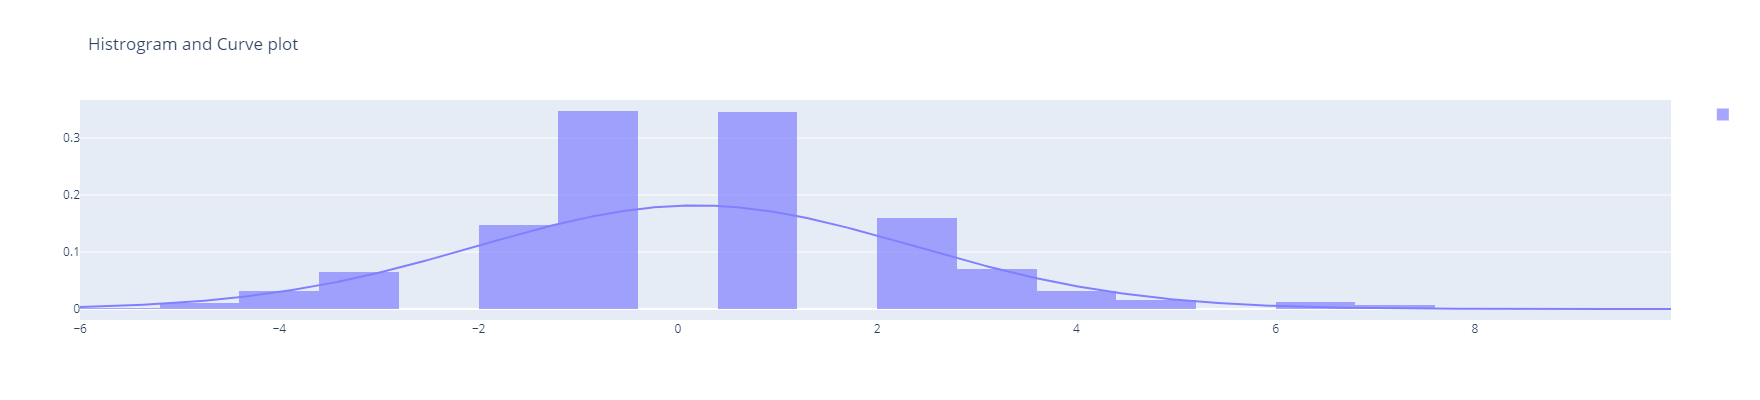

In [26]:
plot_dist(df1.consec_wl)

In [25]:
df1

,open,high,low,close,volume,ret,consec_wl,mae,mfe,pnl,volatile
date,,,,,,,,,,,
2019-07-21 00:00:00+00:00,10765.75,10834.00,10322.00,10588.75,7.400292e+07,-0.016578,-1.0,-0.041219,0.006340,-0.016441,-0.034879
2019-07-22 00:00:00+00:00,10588.75,10688.25,10059.00,10321.50,6.869815e+07,-0.025563,-2.0,-0.050030,0.009397,-0.025239,-0.040633
2019-07-23 00:00:00+00:00,10321.50,10323.25,9776.50,9841.75,9.836957e+07,-0.047596,-3.0,-0.052802,0.000170,-0.046481,-0.052633
2019-07-24 00:00:00+00:00,9835.25,9915.75,9517.75,9770.00,7.770911e+07,-0.007317,-4.0,-0.032921,0.007519,-0.007290,-0.025402
2019-07-25 00:00:00+00:00,9770.00,10185.25,9735.00,9880.75,5.096237e+07,0.011272,1.0,-0.003582,0.042503,0.011336,0.046085
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-11 00:00:00+00:00,39430.00,40273.00,38240.00,38730.00,4.230125e+09,-0.017912,-2.0,-0.030180,0.021380,-0.017753,-0.008800
2022-03-12 00:00:00+00:00,38730.00,39495.00,38662.00,38798.00,1.493118e+09,0.001754,1.0,-0.001756,0.019752,0.001756,0.021508
2022-03-13 00:00:00+00:00,38798.00,39328.00,37570.00,37772.00,1.976823e+09,-0.026801,-1.0,-0.031651,0.013660,-0.026445,-0.017991
